# Import libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Read data in

In [2]:
tennis_data_list = []

for i in range(1999, 2022):
    
    tennis_data_list.append(pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_' + str(i) + '.csv'))

In [3]:
tennis = pd.concat(tennis_data_list, ignore_index = True)

#tennis = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2019.csv')
tennis.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1999-339,Adelaide,Hard,32,A,19990104,1,102158,1.0,NaN,...,28.0,14.0,4.0,7.0,3.0,7.0,4.0,3315.0,115.0,415.0
1,1999-339,Adelaide,Hard,32,A,19990104,2,101792,NaN,NaN,...,41.0,31.0,12.0,11.0,5.0,8.0,64.0,723.0,77.0,635.0
2,1999-339,Adelaide,Hard,32,A,19990104,3,102562,NaN,NaN,...,22.0,12.0,8.0,8.0,3.0,8.0,75.0,669.0,59.0,757.0
3,1999-339,Adelaide,Hard,32,A,19990104,4,103720,NaN,WC,...,44.0,30.0,17.0,11.0,8.0,10.0,100.0,482.0,35.0,1007.0
4,1999-339,Adelaide,Hard,32,A,19990104,5,101727,4.0,NaN,...,25.0,16.0,13.0,8.0,4.0,7.0,27.0,1280.0,81.0,613.0


Find all of the columns to operate on in the data.

In [4]:
tennis.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

Get only the relevant columns for calculating the statistics

In [5]:
tennis_players = tennis.loc[:, ["tourney_date", "winner_id", "winner_name", "winner_age",
                                "loser_id", "loser_name", "loser_age"]]

Convert the columns using functions for dat and age

In [63]:
def convert_columns(df):
    
    df_with_dates = convert_tourney_dates(df)
    
    df_amended_ages = get_player_ages(df_with_dates)
    
    return df_amended_ages

In [64]:
def convert_tourney_dates(df, date_column = "tourney_date"):
    
    df[date_column] = pd.to_datetime(df[date_column], format = "%Y%m%d")
    df["year"] = df[date_column].dt.year
    
    return tennis_players
    

In [65]:
def get_player_ages(df):
    
    # One of the players doesn't have an age
    tennis_players_complete = df[pd.isna(df["winner_age"]) == False]

    tennis_players_complete["winner_age"] = tennis_players_complete["winner_age"].astype(int)
    tennis_players_complete["loser_age"] = tennis_players_complete["loser_age"].astype(int)
    
    return tennis_players_complete

In [66]:
tennis_players_complete = convert_columns(tennis_players)

# Wins and losses of big 3

In [46]:
def filter_players(df, winners, player_list):
     
    if winners == True:
        
        big_3 = df[df["winner_name"].isin(player_list)] 
        
    else:
        
        big_3 = df[df["loser_name"].isin(player_list)]
    
    return big_3
    

In [47]:
big_3 = ["Roger Federer", "Rafael Nadal", "Novak Djokovic"] 

big_3_winning = filter_players(tennis_players_complete, winners = True, player_list = big_3)
big_3_losing = filter_players(tennis_players_complete, winners = False, player_list = big_3)

Create mapping object for players and ID numbers

In [12]:
mapping_players = {"Roger Federer": 103819, "Novak Djokovic": 104925, "Rafael Nadal": 104745}

In [55]:
def get_wins_losses(df_win, df_loss):
    
    total_wins = count_wins_losses(df_win, winning = True)
    
    total_losses = count_wins_losses(df_loss, winning = False)
    
    all_wins_losses = pd.concat([total_wins, total_losses], axis = 1)
    
    all_wins_losses.columns = all_wins_losses.columns.droplevel()
    
    return all_wins_losses

In [56]:
def count_wins_losses(df, winning = True):
    
    if winning == True:
        total = (df.groupby(["winner_name", "winner_age"]).count()
                 .loc[:, ["tourney_date"]].unstack([0]).add_prefix("win_"))
        
    else:
        total = (df.groupby(["loser_name", "loser_age"]).count()
                 .loc[:, ["tourney_date"]].unstack([0]).add_prefix("lose_"))
        
    return total

In [57]:
all_wins_losses = get_wins_losses(big_3_winning, big_3_losing)

In [76]:
def calculate_win_pct(df, pct_list, win_list, loss_list):
    
    new_df = df.copy()
    
    for i, j, k in zip(pct_list, win_list, loss_list):
        
        new_df[i] = (new_df[j] / (new_df[j] + new_df[k])) * 100
        
    win_pct_data = new_df.loc["17":"39", pct_list]
        
    return win_pct_data
    

In [77]:
big_3_pct = ["Djokovic_win_pct", "Nadal_win_pct", "Federer_win_pct"]
big_3_win = ["win_Novak Djokovic", "win_Rafael Nadal", "win_Roger Federer"]
big_3_loss = ["lose_Novak Djokovic", "lose_Rafael Nadal", "lose_Roger Federer"]

win_big_3_percentage = calculate_win_pct(all_wins_losses, player_pct, player_win, player_loss)

# Other players

In [78]:
murray_win = filter_players(df = tennis_players_complete, winners = True, player_list = ["Andy Murray"])
murray_loss = filter_players(df = tennis_players_complete, winners = False, player_list = ["Andy Murray"])

In [79]:
murray_wins_losses = get_wins_losses(murray_win, murray_loss)

In [80]:
win_murray_percentage = calculate_win_pct(murray_wins_losses, ["Murray_win_pct"],
                                          ["win_Andy Murray"], ["lose_Andy Murray"])

# Visualisation

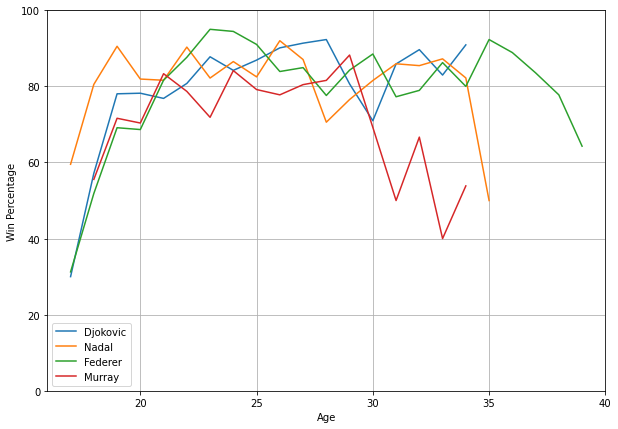

In [84]:
plt.figure(figsize = (10, 7))
plt.plot(win_big_3_percentage["Djokovic_win_pct"], label = "Djokovic")
plt.plot(win_big_3_percentage["Nadal_win_pct"], label = "Nadal")
plt.plot(win_big_3_percentage["Federer_win_pct"], label = "Federer")
plt.plot(win_murray_percentage["Murray_win_pct"], label = "Murray")
plt.xlim(16, 40)
plt.ylim(0, 100)
plt.legend()
plt.grid()
plt.xlabel("Age")
plt.ylabel("Win Percentage")
plt.show()